In [1]:
import sys
sys.path.append('C:/Users/surface/AppData/Local/Programs/Python/Python37/Lib/site-packages')
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import scipy.stats as st 
from hmmlearn import hmm

In [2]:
ts_df=pd.read_csv('ts_csv.csv')
print(ts_df.head())

   Unnamed: 0     id  name                       create_at   cogproc  \
0           0  738.0  迷失路径  Fri Jul 31 18:41:28 +0800 2020  0.140000   
1           1  738.0  迷失路径  Wed Dec 11 16:12:50 +0800 2019  0.053571   
2           2  738.0  迷失路径  Sat Nov 30 12:49:07 +0800 2019  0.104167   
3           3  738.0  迷失路径  Tue Nov 19 18:09:21 +0800 2019  0.333333   
4           4  738.0  迷失路径  Tue Nov 19 12:16:56 +0800 2019  0.122449   

     negemo    negate    affect       bio   discrep    tentat   insight  \
0  0.020000  0.000000  0.020000  0.040000  0.040000  0.020000  0.040000   
1  0.044643  0.017857  0.071429  0.071429  0.053571  0.017857  0.017857   
2  0.020833  0.041667  0.031250  0.000000  0.062500  0.020833  0.020833   
3  0.000000  0.000000  0.166667  0.000000  0.333333  0.333333  0.333333   
4  0.040816  0.040816  0.040816  0.000000  0.061224  0.000000  0.040816   

     health       sad  depressed  isd_cogproc  isd_negemo  isd_negate  \
0  0.000000  0.000000   0.000000     0.0000

In [50]:
seg_list=np.load('C:/Users/surface/Desktop/final project/codes/the whole process/data_feature_engineering/seg_list.npy',allow_pickle=True)
high_cap_data=[]
mid_cap_data=[]
low_cap_data=[]
for i in range(146):
    if len(seg_list[i])>100:
        high_cap_data.append(i)
    if len(seg_list[i])<100 and len(seg_list[i])>30:
        mid_cap_data.append(i)
    if len(seg_list[i])<=30:
        low_cap_data.append(i)
print(len(high_cap_data))
print(high_cap_data)
print(len(mid_cap_data))
print(len(low_cap_data))

53
[2, 4, 12, 13, 15, 16, 17, 20, 21, 22, 29, 33, 34, 42, 48, 51, 52, 55, 58, 59, 61, 62, 68, 69, 70, 73, 76, 77, 81, 82, 88, 91, 92, 100, 101, 105, 107, 109, 114, 115, 116, 117, 119, 122, 124, 126, 127, 128, 130, 132, 134, 139, 145]
49
44


In [51]:
#test the high_cap_data 
#choice_num=random.choice(high_cap_data)
def formateDate(stringdate):
    dt= datetime.strptime(stringdate, "%a %b %d %X %z %Y") #原字符串为"01.12.2013"对应"%d.%m.%Y"
    return dt



c:\users\surface\pycharmprojects\pycharm_packages\venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[0.0, 0.008333333333333331, 0.013461538461538459, 0.013461538461538459, 0.013461538461538459, -1.3877787807814458e-18, 0.016666666666666663, 0.016666666666666663, 0.0, 0.02857142857142857, 0.03333333333333333, 0.05833333333333333, 0.05833333333333333, 0.031249999999999997, 0.006249999999999995, 0.006249999999999995, 0.03243243243243243, 0.03243243243243243, 0.03243243243243243, 0.03719433719433719, 0.03719433719433719, 0.009523809523809518, 0.015975422427035323, 0.016769073220686118, 0.016769073220686118, 0.016769073220686118, 0.029797979797979796, 0.02424242424242424, 0.02424242424242424, -6.245004513516506e-18, -6.245004513516506e-18, -6.245004513516506e-18, 0.003921568627450974, 0.003921568627450974, -6.245004513516506e-18, 0.0054054054054054, 0.055405405405405395, 0.04999999999999999, 0.04999999999999999, -1.1102230246251566e-17, 0.023529411764705875, 0.023529411764705875, 0.023529411764705875, 0.22352941176470587, 0.20425531914893616, 0.20425531914893616, 0.004255319148936155, 0.0

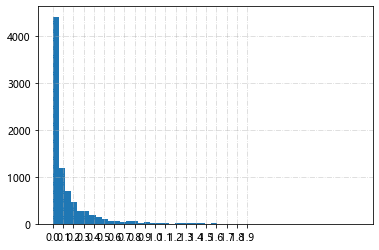

In [132]:
all_user_mixneg=[]
all_user_neg_preserve=[]
mix_neg_data_all=[]

for choice_num in high_cap_data:
    user_df=ts_df.iloc[seg_list[choice_num][0]:seg_list[choice_num][len(seg_list[choice_num])-1],:]
    user_df['create_at']=user_df['create_at'].apply(formateDate)
    user_df=user_df.sort_values(by="create_at" , ascending=True)
    user_df=user_df.set_index('create_at',drop=False)
    
    user_df['depressed_3d']=user_df['depressed'].rolling('3d').sum()
    user_df['negemo_3d']=user_df['negemo'].rolling('3d').sum()
    
    user_depressed_3d=user_df['depressed_3d'].tolist()
    user_negemo_3d=user_df['negemo_3d'].tolist()
    
    user_negmixed=[]
    for i in range(len(user_depressed_3d)):
        mix_neg_score=0.6*float(user_depressed_3d[i])+0.4*float(user_negemo_3d[i])
        user_negmixed.append(mix_neg_score)
        mix_neg_data_all.append(mix_neg_score)
    all_user_mixneg.append(user_negmixed)
    all_user_neg_preserve.append(user_negmixed)
np.save("all_user_neg_preserve.npy",all_user_neg_preserve)
    
print(all_user_mixneg[0])
print(len(all_user_mixneg))
print(len(mix_neg_data_all))

print(st.anderson (mix_neg_data_all, dist ='norm'))
#数据相当不正态，当然这是可预见的，把他作为离散值进行处理
print(max(mix_neg_data_all),min(mix_neg_data_all))

plt.figure()
x = mix_neg_data_all
plt.hist(x,bins=50)  
plt.xticks(np.arange(0,2,0.1))
plt.grid(alpha=0.5,linestyle='-.')

all_label=[]
for i in range(len(all_user_mixneg)):
    for j in range(len(all_user_mixneg[i])):
        if all_user_mixneg[i][j]<=0 :
            all_user_mixneg[i][j]=0
        elif all_user_mixneg[i][j]>0 and all_user_mixneg[i][j]<=0.1:
            all_user_mixneg[i][j]=1
        elif all_user_mixneg[i][j]>0.1 and all_user_mixneg[i][j]<=0.5:
            all_user_mixneg[i][j]=2        
        else:
            all_user_mixneg[i][j]=3
        all_label.append(all_user_mixneg[i][j])

[[0], [1], [1], [1], [1], [0], [1], [1], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [1], [1], [0], [1], [1], [1], [1], [0], [1], [1], [1], [2], [2], [2], [1], [1], [0], [1], [2], [2], [1], [1], [1], [1], [1], [1], [1], [0], [0], [1], [2], [2], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [1], [1], [2], [2], [2], [2], [1], [0], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [1], [1], [1], [0], [0], [1], [1], [1], [1], [0], [0], [0], [1], [1], [1], [1], [0], [1], [1], [1], [1], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [1], [1], [2], [2], [2], [2], [2], [3], [3], [3], [2], [1], [1], [1], [2], [2], [2], [2], [2], [2], [1], [1], [2], [2], [2], [1], [2], [2], [3], [3], [3], [3], [3], [3], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [2], [1], [2], [2], [2], [2], [1], [1],

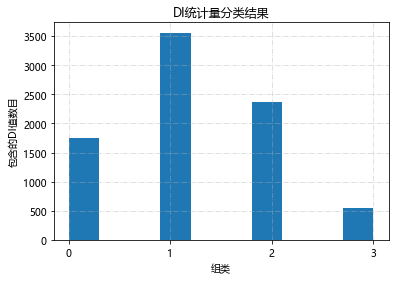

In [133]:
for user in all_user_mixneg:
    for i in range(len(user)):
        user[i]=[user[i]]
#检查分类状况是否合理
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.figure()
x = all_label
plt.hist(x)  
plt.xticks(np.arange(0,4,1))
plt.title("DI统计量分类结果")
plt.xlabel("组类")
plt.ylabel("包含的DI值数目")
plt.grid(alpha=0.5,linestyle='-.')
plt.savefig("DI_result.png")
x=[]
for item in all_label:
    x.append([item])
print(x)

length=[]
for user in all_user_mixneg:
    length.append(len(user))

In [149]:
choice_user=0
choice_num=high_cap_data[choice_user]
user_df=ts_df.iloc[seg_list[choice_num][0]:seg_list[choice_num][len(seg_list[choice_num])-1],:]
print(user_df.iloc[0]["name"])

X=all_user_mixneg[choice_user]
print(X)
states = ["state1", "state2","state3"]
n_states = len(states)

observations = ["lv_a", "lv_b","lv_c","lv_d"]
n_observations = len(observations)

model = hmm.MultinomialHMM(n_components=n_states, n_iter=200)

#model.score __ Compute the log probability under the model 
model_score=-100000000
model_startprob=[]
model_transmat=[]
model_emissionprob=[]


print("first run\n")
model.fit(X)
print ("fit_score: ", model.score(X))
if model.score(X)>model_score:
    model_score=model.score(X)
    model_startprob=model.startprob_
    model_transmat=model.transmat_
    model_emissionprob=model.emissionprob_

print('_______________________')
print("second run\n")
model.fit(X)
print ("fit_score: ", model.score(X))
if model.score(X)>model_score:
    model_score=model.score(X)
    model_startprob=model.startprob_
    model_transmat=model.transmat_
    model_emissionprob=model.emissionprob_
print("_______________________")
print("third run\n")
print ("fit_score: ", model.score(X))
if model.score(X)>model_score:
    model_score=model.score(X)
    model_startprob=model.startprob_
    model_transmat=model.transmat_
    model_emissionprob=model.emissionprob_
print("_______________________")
print("forth run\n")
model.fit(X)
print ("fit_score: ", model.score(X))
if model.score(X)>model_score:
    model_score=model.score(X)
    model_startprob=model.startprob_
    model_transmat=model.transmat_
    model_emissionprob=model.emissionprob_
print("_______________________")

print("selected model score:",model_score)
print(model_startprob)
print(model_transmat)
print(model_emissionprob)



Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


蓝丝绒Whisky
[[1], [1], [0], [0], [0], [0], [0], [1], [1], [1], [1], [0], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [1], [1], [1], [1], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [3], [0], [0], [0], [1], [1], [1], [0], [1], [0], [1], [1], [1], [1], [1], [1], [1], [0], [1], [1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [2], [0], [0], [1], [1], [1], [0], [0]]
first run

fit_score:  -97.55896165551387
_______________________
second run

fit_score:  -121

In [150]:
startprob = model_startprob
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = model_transmat

# The means of each component
emissionprob_ = model_emissionprob

states = ["state_1", "state_2","state3"]
n_states = len(states)

observations = ["lv_a", "lv_b","lv_c","lv_d"]

model = hmm.MultinomialHMM(n_components=n_states, n_iter=20)
# Build an HMM instance and set parameters

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob_


# Generate samples
logprob, hd_state_ori = model.decode(X, algorithm="viterbi")
# Plot the sampled data
print("The hidden state ori", ", ".join(map(lambda x: states[x], hd_state_ori)))
print(hd_state_ori)

emissionprob_matrix=model.emissionprob_
weight=[0,5,30,75]
state_weight=[]
for state in emissionprob_matrix:
    weight_sum=0
    for i in range(len(state)):
        weight_sum=weight_sum+state[i]*weight[i]
    state_weight.append(weight_sum)
print(state_weight)
max_wei=max(state_weight)
min_wei=min(state_weight)
for i in range(len(state_weight)):
    if state_weight[i]==max_wei:
       state_weight[i]=2
    elif state_weight[i]==min_wei:
       state_weight[i]=0
    else:
       state_weight[i]=1
        
print(state_weight)
hd_state=[]
for i in hd_state_ori:
    hd_state.append(state_weight[i])
print(hd_state)

ob_state=[]
for x_item in X:
    ob_state.append(x_item[0])


print(ob_state)



The hidden state ori state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_2, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1, state_1

c:\users\surface\pycharmprojects\pycharm_packages\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.02564102564102564, 0.02564102564102564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.019230769230769232, 0.0, 0.020408163265306117, 0.020408163265306117, 0.1, 0.1, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.20000000000000004, 0.20000000000000004, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 0.16666666666666669, 0.16666666666666669, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 2.7755575615628914e-17, 0.10000000000000003, 0.10000000000000003, 0.10000000000000003, 0.10000000000000003, 0.10000000000000003, 2.775557

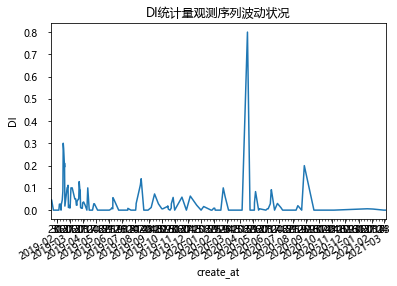

In [151]:
choice_num=high_cap_data[choice_user]

user_df=ts_df.iloc[seg_list[choice_num][0]:seg_list[choice_num][len(seg_list[choice_num])-1],:]
user_df['create_at']=user_df['create_at'].apply(formateDate)
user_df=user_df.sort_values(by="create_at" , ascending=True)

user_df=user_df.set_index('create_at',drop=False)

user_df['depressed_3d']=user_df['depressed'].rolling('3d').sum()
user_df['negemo_3d']=user_df['negemo'].rolling('3d').sum()


user_depressed_3d=user_df['depressed_3d'].tolist()
print(user_depressed_3d)
user_df["hidden_state"]=hd_state
print(hd_state)

all_user_neg_preserve=np.load("all_user_neg_preserve.npy",allow_pickle=True)
user_df["mix_negemo"]=all_user_neg_preserve[choice_user]

print(user_df.head())

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

fig=plt.figure()
ax1=fig.add_subplot(1,1,1) 
plt.title("DI统计量观测序列波动状况")
plt.xlabel("Date")
plt.ylabel("DI")
plt.gcf().autofmt_xdate()
alldays = mdates.MonthLocator()     
user_df['mix_negemo'].plot()
ax1.xaxis.set_major_locator(alldays)  

datesLoc = mdates.DayLocator(interval=7) 
ax1.xaxis.set_minor_locator(datesLoc)
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
#参数pad用于设置刻度线与标签间的距离
ax1.tick_params(pad=10)



plt.savefig("DI.png")
#

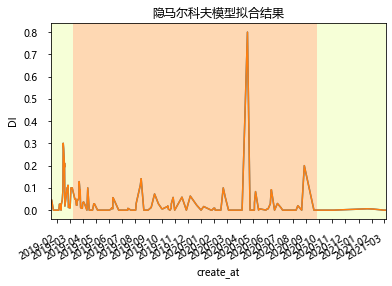

In [152]:
fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
ax = user_df['mix_negemo'].plot()
plt.xlabel("Date")
plt.ylabel("DI")
plt.gcf().autofmt_xdate()
alldays = mdates.MonthLocator()     
user_df['mix_negemo'].plot()
ax1.xaxis.set_major_locator(alldays)  

datesLoc = mdates.DayLocator(interval=7) 
#ax1.xaxis.set_minor_locator(datesLoc)
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
#参数pad用于设置刻度线与标签间的距离
ax1.tick_params(pad=10)
plt.title("隐马尔科夫模型拟合结果")
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              user_df['hidden_state'].values[np.newaxis],
              cmap='Wistia', alpha=0.3)
name=str(user_df.iloc[0]["name"])
path="C:/Users/surface/Desktop/final project/codes/the whole process/time_series_analysis/results/result"+str(choice_user)+"_"+name+"_"+".png"
plt.savefig(path)
